<a href="https://colab.research.google.com/github/MeiyingOrAmy/FL-Client-Contribution-Evaluation-with-FedTruth/blob/main/FRECA_FL_client_contrib_eval_FedTruth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries, download data

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [ ]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pickle
from collections import defaultdict
from itertools import combinations

In [ ]:
# Download data
training_data = datasets.MNIST(
    root="data/mnist",
    train=True,
    download=True,
    transform=ToTensor(),
)

test_data = datasets.MNIST(
    root="data/mnist",
    train=False,
    download=True,
    transform=ToTensor(),
)

100%|██████████| 9912422/9912422 [00:00<00:00, 106966152.82it/s]


Extracting data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to data/mnist/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 99782284.86it/s]


Extracting data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to data/mnist/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 54728619.00it/s]


Extracting data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to data/mnist/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 19864993.50it/s]

Extracting data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/mnist/MNIST/raw



# Set Client Data

In [ ]:
# Set client data
def sample_client(dataset, num_users):
    """
    Random Sample equal size client data from MNIST dataset
    :param dataset:
    :param num_users:
    :return: dict of image index
    """
    num_items = int(len(dataset)/num_users)
    dict_users, all_idxs = {}, [i for i in range(len(dataset))]
    for i in range(num_users):
        # np.random.seed(1)
        dict_users[i] = set(np.random.choice(all_idxs, num_items,
                                             replace=False))
        all_idxs = list(set(all_idxs) - dict_users[i])
    return dict_users

In [ ]:
# Set client data: different data size
def sample_client_diffsize(dataset, num_users, num_items):
    """
    Random Sample non-equal size client data from MNIST dataset
    :param dataset:
    :param num_users:
    :param num_items: number of items for each client (list)
    :return: dict of image index
    """
    assert len(num_items) == num_users

    dict_users, all_idxs = {}, [i for i in range(len(dataset))]
    for i in range(num_users):
        # np.random.seed(1)
        dict_users[i] = set(np.random.choice(all_idxs, num_items[i],
                                             replace=False))
        all_idxs = list(set(all_idxs) - dict_users[i])
    return dict_users

In [ ]:
# Set client data: same size, strictly iid
def sample_client_iid(dataset, num_users, num_items = None):
    if num_items is None:
      num_items = int(len(dataset)/num_users)

    num_labels = len(dataset.classes)
    num_label_items = int(num_items/num_labels)

    dict_users = {}

    # Dictionary to store the list of indices for each class label
    label_indices = defaultdict(list)

    # Record the indices for each class label
    for index, (_, label) in enumerate(dataset):
        label_indices[label].append(index)

    for i in range(num_users):
        dict_users[i] = set()
        for label in range(num_labels):
            # np.random.seed(1)
            if len(label_indices[label]) < num_label_items:
                more_items = num_label_items - len(label_indices[label])
                dict_users[i] = dict_users[i].union(set(label_indices[label]))
                label_indices[label] = [i for i, (image, lab) in enumerate(dataset) if lab == label]
                dict_users[i] = dict_users[i].union(set(np.random.choice(label_indices[label], more_items,
                                                                 replace=False)))
                label_indices[label] = list(set(label_indices[label]) - dict_users[i])
            else:
                dict_users[i] = dict_users[i].union(set(np.random.choice(label_indices[label], num_label_items,
                                                                    replace=False)))
                label_indices[label] = list(set(label_indices[label]) - dict_users[i])

    return dict_users

In [ ]:
# Set client data: same size, non iid
def sample_client_non_iid(dataset, num_users, user_num_labels, num_items = None):
    """
    Sample non-iid client data from MNIST dataset
    :param user_num_labels: number of labels for each client (list)
    :param num_items: number of items for each client (int)
    :return: dict of index
    """
    assert len(user_num_labels) == num_users

    if num_items is None:
      num_items = int(len(dataset)/num_users)

    num_labels = len(dataset.classes)

    dict_users = {}

    # Dictionary to store the list of indices for each class label
    label_indices = defaultdict(list)

    # Record the indices for each class label
    for index, (_, label) in enumerate(dataset):
        label_indices[label].append(index)

    for i in range(num_users):
        dict_users[i] = set()
        # np.random.seed(1)
        user_label_list = np.random.choice(list(range(num_labels)), user_num_labels[i], replace=False)
        num_label_items = int(num_items/user_num_labels[i])

        for label in user_label_list:
            # np.random.seed(1)
            if len(label_indices[label]) < num_label_items:
                more_items = num_label_items - len(label_indices[label])
                dict_users[i] = dict_users[i].union(set(label_indices[label]))
                label_indices[label] = [i for i, (image, lab) in enumerate(dataset) if lab == label]
                dict_users[i] = dict_users[i].union(set(np.random.choice(label_indices[label], more_items,
                                                                 replace=False)))
                label_indices[label] = list(set(label_indices[label]) - dict_users[i])
            else:
                dict_users[i] = dict_users[i].union(set(np.random.choice(label_indices[label], num_label_items,
                                                                    replace=False)))
                label_indices[label] = list(set(label_indices[label]) - dict_users[i])

    return dict_users

In [ ]:
# Set client data: diff size, non iid
def sample_client_non_iid_diff_size(dataset, num_users, user_num_labels, user_num_items):
    """
    Sample non-iid client data from MNIST dataset
    :param user_num_labels: number of labels for each client (list)
    :param user_num_items: number of items for each client (list)
    :return: dict of index
    """
    assert len(user_num_labels) == num_users
    assert len(user_num_items) == num_users

    num_labels = len(dataset.classes)

    dict_users = {}

    # Dictionary to store the list of indices for each class label
    label_indices = defaultdict(list)

    # Record the indices for each class label
    for index, (_, label) in enumerate(dataset):
        label_indices[label].append(index)

    for i in range(num_users):
        dict_users[i] = set()
        # np.random.seed(1)
        user_label_list = np.random.choice(list(range(num_labels)), user_num_labels[i], replace=False)
        num_label_items = int(user_num_items[i]/user_num_labels[i])

        for label in user_label_list:
            # np.random.seed(1)
            if len(label_indices[label]) < num_label_items:
                more_items = num_label_items - len(label_indices[label])
                dict_users[i] = dict_users[i].union(set(label_indices[label]))
                label_indices[label] = [i for i, (image, lab) in enumerate(dataset) if lab == label]
                dict_users[i] = dict_users[i].union(set(np.random.choice(label_indices[label], more_items,
                                                                 replace=False)))
                label_indices[label] = list(set(label_indices[label]) - dict_users[i])
            else:
                dict_users[i] = dict_users[i].union(set(np.random.choice(label_indices[label], num_label_items,
                                                                    replace=False)))
                label_indices[label] = list(set(label_indices[label]) - dict_users[i])

    return dict_users

In [ ]:
# Set client data: diff size, non iid
def sample_client_non_iid_rotate(dataset, num_users, user_num_labels, user_num_items):
    """
    Sample non-iid client data from MNIST dataset
    :param user_num_labels: number of labels for each client (list)
    :param user_num_items: number of items for each client (list)
    :return: dict of index
    """
    assert len(user_num_labels) == num_users
    assert len(user_num_items) == num_users

    num_labels = len(dataset.classes)

    dict_users = {}

    # Dictionary to store the list of indices for each class label
    label_indices = defaultdict(list)

    # Record the indices for each class label
    for index, (_, label) in enumerate(dataset):
        label_indices[label].append(index)

    labels = list(range(num_labels))

    for i in range(num_users):
        dict_users[i] = set()
        if len(labels) < user_num_labels[i]:
            more_labels = user_num_labels[i] - len(labels)
            user_label_list = np.random.choice(labels, len(labels), replace=False)
            labels = list(range(num_labels))
            more_label_list = np.random.choice(labels, more_labels, replace=False)
            user_label_list = np.concatenate((user_label_list, more_label_list))
            labels = list(set(labels) - set(more_label_list))
        else:
            user_label_list = np.random.choice(labels, user_num_labels[i], replace=False)
            labels = list(set(labels) - set(user_label_list))

        num_label_items = int(user_num_items[i]/user_num_labels[i])

        for label in user_label_list:
            # np.random.seed(1)
            if len(label_indices[label]) < num_label_items:
                more_items = num_label_items - len(label_indices[label])
                dict_users[i] = dict_users[i].union(set(label_indices[label]))
                label_indices[label] = [i for i, (image, lab) in enumerate(dataset) if lab == label]
                dict_users[i] = dict_users[i].union(set(np.random.choice(label_indices[label], more_items,
                                                                 replace=False)))
                label_indices[label] = list(set(label_indices[label]) - dict_users[i])
            else:
                dict_users[i] = dict_users[i].union(set(np.random.choice(label_indices[label], num_label_items,
                                                                    replace=False)))
                label_indices[label] = list(set(label_indices[label]) - dict_users[i])

    return dict_users

In [ ]:
# See client data distribution
def client_distribution(dataset, dict_users):
    """
    Find client data distribution
    :param dict_users: dict of image index returned from one of sample_client methods
    :return: matrix of num_users x num_labels, each row is a client distribution
    """
    num_users = len(dict_users)
    num_labels = len(dataset.classes)
    distrib_matrix = np.zeros((num_users, num_labels))

    for i in range(num_users):
      user_dataset = torch.utils.data.Subset(dataset, list(dict_users[i]))
      # Count the occurrences of each class label
      for _, label in user_dataset:
          distrib_matrix[i, label] += 1

    return distrib_matrix

# Model Settings

In [ ]:
# Define CNN model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)

        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)

        return x


In [ ]:
# Define Train
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [ ]:
# Define Test
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    # print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return correct

In [ ]:
# Get device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [ ]:
batch_size = 64
test_dataloader = DataLoader(test_data, batch_size=batch_size)
loss_fn = nn.CrossEntropyLoss()

# Client Contribution: LOO, Shapley

In [ ]:
# calculate the softmax of a np array
def softmax(arr):
  # softmax for each row
  if len(arr.shape)==1:
    e = np.exp(arr)
    return e / e.sum()
  else:
    lst = []
    for i in range(arr.shape[0]):
      vector = arr[i,:]
      e = np.exp(vector)
      lst.append(e / e.sum())
    return np.array(lst)

softmax(np.array([1,2,3]))


array([0.09003057, 0.24472847, 0.66524096])

In [ ]:
# Min-max Scaling
def minmaxscale(arr):
  # 1d array
  if len(arr.shape)==1:
    e = (arr-np.min(arr))/(np.max(arr)-np.min(arr))
    return e / e.sum()

  # multi-row array
  else:
    lst = []
    for i in range(arr.shape[0]):
      vector = arr[i,:]
      e = (vector-np.min(vector))/(np.max(vector)-np.min(vector))
      lst.append(e / e.sum())
    return np.array(lst)

# example
minmaxscale(np.array([1,2,3]))

array([0.        , 0.33333333, 0.66666667])

In [ ]:
# Client Contribution (loo)
def client_contribution_loo(local_state_dict, client_weights):
  # Compute client contribution based on leave-one-out method.
  # loo = u1 - u2, where u1 is normaly aggregated model's test accuracy,
  # u2 is test accuracy of model aggregated without i-th client.

  assert len(local_state_dict) == len(client_weights)
  n = len(local_state_dict)

  # compute u1
  agg_model = NeuralNetwork().to(device)
  agg_state_dict = {}
  for key, value in agg_model.state_dict().items():
    agg_state_dict[key] = torch.zeros_like(value).to(device)
    for i in range(n):
      agg_state_dict[key] += local_state_dict[i][key] * client_weights[i]

  agg_model.load_state_dict(agg_state_dict)

  u1 = [test(test_dataloader, agg_model, loss_fn) for i in range(n)]

  # compute u2
  u2 = []
  for i in range(n):
    agg_model = NeuralNetwork().to(device)
    agg_state_dict = {}
    for key, value in agg_model.state_dict().items():
      agg_state_dict[key] = torch.zeros_like(value).to(device)
      sum_weights = 0
      for j in range(n):
        if j==i: continue
        sum_weights += client_weights[j]
        agg_state_dict[key] += local_state_dict[j][key] * client_weights[j]
      agg_state_dict[key] = agg_state_dict[key] / sum_weights

    agg_model.load_state_dict(agg_state_dict)
    u2.append(test(test_dataloader, agg_model, loss_fn))

  return [u1[i] - u2[i] for i in range(n)]

In [ ]:
def all_subsets_lst(ls):
  subsets = [[]]

  for el in ls:
      subsets += [s+[el] for s in subsets]

  return subsets

all_subsets_lst([0,1,2])

[[], [0], [1], [0, 1], [2], [0, 2], [1, 2], [0, 1, 2]]

In [ ]:
# Client Contribution (shapley)
def client_contribution_shap(local_state_dict, client_weights, global_state_dict):
  # Compute client contribution based on Shapley value method.
  # For each subset without client i, compute utility (test accuracy) difference
  # with and without i, and take average over all subsets.
  # local_state_dict: list of local models
  # client_weights: list of aggregation weights
  # gloabel_state_dict: global model before aggregation

  assert len(local_state_dict) == len(client_weights)
  n = len(local_state_dict)

  # compute u_prev: utility of global model before aggregation
  glob_model = NeuralNetwork().to(device)
  glob_model.load_state_dict(global_state_dict)
  u_prev = test(test_dataloader, glob_model, loss_fn)

  def utility(subset):
    # subset: list of client indices
    if len(subset)==0: return u_prev
    else:
      agg_model = NeuralNetwork().to(device)
      agg_state_dict = {}
      for key, value in agg_model.state_dict().items():
        agg_state_dict[key] = torch.zeros_like(value).to(device)
        sum_weights = 0
        for i in subset:
          sum_weights += client_weights[i]
          agg_state_dict[key] += local_state_dict[i][key] * client_weights[i]
        agg_state_dict[key] = agg_state_dict[key] / sum_weights
      agg_model.load_state_dict(agg_state_dict)
      return test(test_dataloader, agg_model, loss_fn)

  # compute shapley value
  sv = []
  for i in range(n):
    ls = list(range(n))
    ls.remove(i)
    subs = all_subsets_lst(ls)
    svi = 0
    for sub in subs:
      svi += (utility(sub + [i]) - utility(sub)) / math.comb(n-1, len(sub))
    sv.append(svi/n)

  return sv

In [ ]:
def all_subsets(s):
    return [subset for r in range(len(s)+1) for subset in combinations(s, r)]

# Example
all_subsets(range(3))

[(), (0,), (1,), (2,), (0, 1), (0, 2), (1, 2), (0, 1, 2)]

In [ ]:
# Client Contribution (shapley): more efficient
def client_contribution_shap_eff(local_state_dict, client_weights, global_state_dict):
  # Compute client contribution based on Shapley value method.
  # For each subset without client i, compute utility (test accuracy) difference
  # with and without i, and take average over all subsets.
  # local_state_dict: list of local models
  # client_weights: list of aggregation weights
  # gloabel_state_dict: global model before aggregation

  assert len(local_state_dict) == len(client_weights)
  n = len(local_state_dict)

  # compute u_prev: utility of global model before aggregation
  glob_model = NeuralNetwork().to(device)
  glob_model.load_state_dict(global_state_dict)
  u_prev = test(test_dataloader, glob_model, loss_fn)

  def utility(subset):
    # subset: list/tuple of client indices
    if len(subset)==0: return u_prev
    else:
      agg_model = NeuralNetwork().to(device)
      agg_state_dict = {}
      for key, value in agg_model.state_dict().items():
        agg_state_dict[key] = torch.zeros_like(value).to(device)
        sum_weights = 0
        for i in subset:
          sum_weights += client_weights[i]
          agg_state_dict[key] += local_state_dict[i][key] * client_weights[i]
        agg_state_dict[key] = agg_state_dict[key] / sum_weights
      agg_model.load_state_dict(agg_state_dict)
      return test(test_dataloader, agg_model, loss_fn)

  # compute shapley value
  utility_dict = {}
  for subset in all_subsets(range(n)):
    utility_dict[subset] = utility(subset)

  sv = []
  for i in range(n):
    ls = list(range(n))
    ls.remove(i)
    subs = all_subsets(ls)
    svi = 0
    for sub in subs:
      svi += (utility_dict[tuple(set(sub).union([i]))] - utility_dict[sub]) / math.comb(n-1, len(sub))
    sv.append(svi/n)

  return sv

In [ ]:
# Client Contribution (shapley): more efficient
def client_contribution_shap_fedtruth(local_state_dict, client_weights, global_state_dict):
  # Compute client contribution based on Shapley value method.
  # For each subset without client i, compute utility (test accuracy) difference
  # with and without i, and take average over all subsets.
  # local_state_dict: list of local models
  # client_weights: list of aggregation weights
  # gloabel_state_dict: global model before aggregation

  assert len(local_state_dict) == len(client_weights)
  n = len(local_state_dict)

  # compute u_prev: utility of global model before aggregation
  glob_model = NeuralNetwork().to(device)
  glob_model.load_state_dict(global_state_dict)
  u_prev = test(test_dataloader, glob_model, loss_fn)

  def utility(subset):
    # subset: list/tuple of client indices
    if len(subset)==0: return u_prev
    elif len(subset)==1:
      agg_model = NeuralNetwork().to(device)
      agg_model.load_state_dict(local_state_dict[subset[0]])
      return test(test_dataloader, agg_model, loss_fn)
    else:
      agg_model = NeuralNetwork().to(device)
      agg_state_dict, obj, aw, contrib = fedtruth([local_state_dict[i] for i in subset],
                                                  [client_weights[i] for i in subset], n_iter=50)
      agg_model.load_state_dict(agg_state_dict)
      return test(test_dataloader, agg_model, loss_fn)

  # compute shapley value
  utility_dict = {}
  for subset in all_subsets(range(n)):
    utility_dict[subset] = utility(subset)

  sv = []
  for i in range(n):
    ls = list(range(n))
    ls.remove(i)
    subs = all_subsets(ls)
    svi = 0
    for sub in subs:
      svi += (utility_dict[tuple(set(sub).union([i]))] - utility_dict[sub]) / math.comb(n-1, len(sub))
    sv.append(svi/n)

  return sv

# FedTruth

In [ ]:
def euclidean_distance(tensor1, tensor2):
    # Ensure tensors are of the same size
    assert tensor1.size() == tensor2.size(), "Tensors must have the same size"

    # Compute the element-wise squared difference
    squared_diff = (tensor1 - tensor2)**2

    # Sum the squared differences and take the square root
    distance = torch.sqrt(torch.sum(squared_diff))

    return distance.item()  # Convert the result to a Python float

In [ ]:
# # FedTruth Aggregation
# def fedtruth(local_state_dict, client_weights, n_iter=50):
#   # Compute FedTruth aggregation.
#   # local_state_dict: list of local model state dicts
#   # client_weights: list of aggregation weights
#   # Return: agg_state_dict, ojb

#   assert len(local_state_dict) == len(client_weights)
#   n = len(local_state_dict)

#   # compute initial truth
#   agg_state_dict = {}
#   for key, value in local_state_dict[0].items():
#     agg_state_dict[key] = torch.zeros_like(value).to(device)
#     for i in range(n):
#       agg_state_dict[key] += local_state_dict[i][key] * client_weights[i]
#   # flatten
#   truth = torch.cat([param.view(-1) for param in agg_state_dict.values()])

#   # flatten local models
#   local_flat = []
#   for i in range(n):
#     local_flat.append(torch.cat([param.view(-1) for param in local_state_dict[i].values()]))

#   # iterate
#   obj = []
#   for i in range(n_iter):
#     # compute weights
#     # distance (Euclidean)
#     dist = []
#     for j in range(n):
#       dist.append(euclidean_distance(truth, local_flat[j]))
#     # performance value
#     pv = [dist[j] / sum(dist) for j in range(n)]
#     # coefficient function g()=-log(p)
#     cf = [-math.log(pv[j]) for j in range(n)]
#     # aggregation weight
#     aw = [cf[j] / sum(cf) for j in range(n)]

#     # objective function
#     obj.append(sum([cf[j] * dist[j] for j in range(n)]))

#     # update truth
#     truth = sum([local_flat[j] * aw[j] for j in range(n)])

#   # compute contribution: converted fraction in final objective function
#   obj_fin = [cf[j] * dist[j] for j in range(n)]
#   gap = [obj_fin[j] / sum(obj_fin) for j in range(n)]

#   # convert function
#   def convert(x):
#     # solve equation sum(z)=1; z[i]/z[j]=x[j]/x[i]
#     y = [1 for i in range(len(x))]
#     for i in range(len(y)):
#       if i==0: pass
#       else:
#         y[i] = x[0]*y[0]/x[i]
#     z = [y[i] / sum(y) for i in range(len(y))]
#     return z

#   contrib = convert(gap)

#   # unflattern final truth
#   start_idx = 0
#   for name, param in agg_state_dict.items():
#       param_size = param.numel()
#       param.data = truth[start_idx:start_idx + param_size].view(param.size())
#       start_idx += param_size

#   return agg_state_dict, obj, aw, contrib


In [ ]:
# FedTruth Aggregation update: update coefficient function
def fedtruth(local_state_dict, client_weights, n_iter=50):
  # Compute FedTruth aggregation.
  # local_state_dict: list of local model state dicts
  # client_weights: list of aggregation weights
  # Return: agg_state_dict, ojb

  assert len(local_state_dict) == len(client_weights)
  n = len(local_state_dict)

  # compute initial truth
  agg_state_dict = {}
  for key, value in local_state_dict[0].items():
    agg_state_dict[key] = torch.zeros_like(value).to(device)
    for i in range(n):
      agg_state_dict[key] += local_state_dict[i][key] * client_weights[i]
  # flatten
  truth = torch.cat([param.view(-1) for param in agg_state_dict.values()])

  # flatten local models
  local_flat = []
  for i in range(n):
    local_flat.append(torch.cat([param.view(-1) for param in local_state_dict[i].values()]))

  # iterate
  obj = []
  for i in range(n_iter):
    # compute weights
    # distance (Euclidean)
    dist = []
    for j in range(n):
      dist.append(euclidean_distance(truth, local_flat[j]))
    # performance value
    pv = [dist[j] / sum(dist) for j in range(n)]
 # # coefficient function g()=-log(p)
    # cf = [-math.log(pv[j]) for j in range(n)]

    # coefficient function g()=1/p
    cf = [1/(pv[j]) for j in range(n)]
    # aggregation weight
    aw = [cf[j] / sum(cf) for j in range(n)]

    # objective function
    obj.append(sum([cf[j] * dist[j] for j in range(n)]))

    # update truth
    truth = sum([local_flat[j] * aw[j] for j in range(n)])

  # compute contribution: converted fraction in final objective function
  obj_fin = [cf[j] * dist[j] for j in range(n)]
  gap = [obj_fin[j] / sum(obj_fin) for j in range(n)]

  # convert function
  def convert(x):
    # solve equation sum(z)=1; z[i]/z[j]=x[j]/x[i]
    y = [1 for i in range(len(x))]
    for i in range(len(y)):
      if i==0: pass
      else:
        y[i] = x[0]*y[0]/x[i]
    z = [y[i] / sum(y) for i in range(len(y))]
    return z

  contrib = convert(gap)

  # unflattern final truth
  start_idx = 0
  for name, param in agg_state_dict.items():
      param_size = param.numel()
      param.data = truth[start_idx:start_idx + param_size].view(param.size())
      start_idx += param_size

  return agg_state_dict, obj, aw, contrib


# Experiment 040: 1-2 lable per client CNN

In [ ]:
# Settings
num_clients = 8
epochs = 30
# batch_size = 64
local_epochs = 10

user_num_labels = [1, 1, 1, 1, 1, 1, 2, 2]
user_num_items = [5000, 5000, 5000, 5000, 5000, 5000, 10000, 10000]

# client_data = sample_client_non_iid(training_data, num_clients, user_num_labels, num_items = 6000)
client_data = sample_client_non_iid_rotate(training_data, num_clients, user_num_labels, user_num_items)

print(client_distribution(training_data, client_data))

# Attack settings
bad_client = ()   # no attack
# bad_client = (7,)   # index of bad users
amp = 10    # attacker amplify local model by 10

[[   0.    0.    0. 5000.    0.    0.    0.    0.    0.    0.]
 [   0.    0. 5000.    0.    0.    0.    0.    0.    0.    0.]
 [5000.    0.    0.    0.    0.    0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0. 5000.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0. 5000.    0.]
 [   0.    0.    0.    0.    0.    0. 5000.    0.    0.    0.]
 [   0.    0.    0.    0. 5000.    0.    0.    0.    0. 5000.]
 [   0. 5000.    0.    0.    0. 5000.    0.    0.    0.    0.]]


Epoch 1
-------------------------------
	Client 0
-----------------------
loss: 2.265124  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
	Client 1
-----------------------
loss: 2.317196  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
	Client 2
-----------------------
loss: 2.353460  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [ 

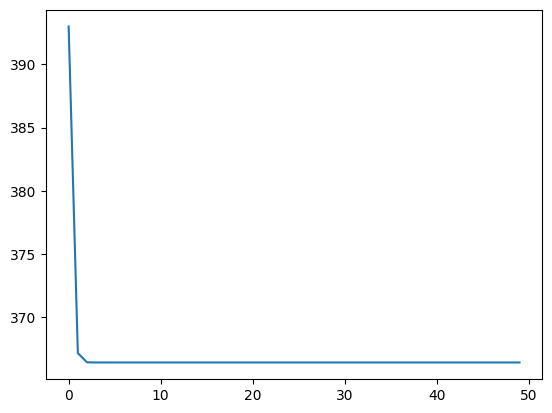

Test accuracy:  0.0958
Epoch 2
-------------------------------
	Client 0
-----------------------
loss: 0.908606  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
	Client 1
-----------------------
loss: 4.133500  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
	Client 2
-----------------------
loss: 4.649410  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5

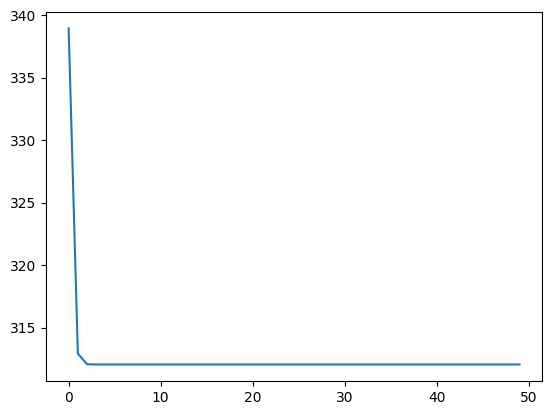

Test accuracy:  0.098
Epoch 3
-------------------------------
	Client 0
-----------------------
loss: 7.129231  [   64/ 5000]
loss: 0.000003  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
	Client 1
-----------------------
loss: 1.740394  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
	Client 2
-----------------------
loss: 0.431835  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 50

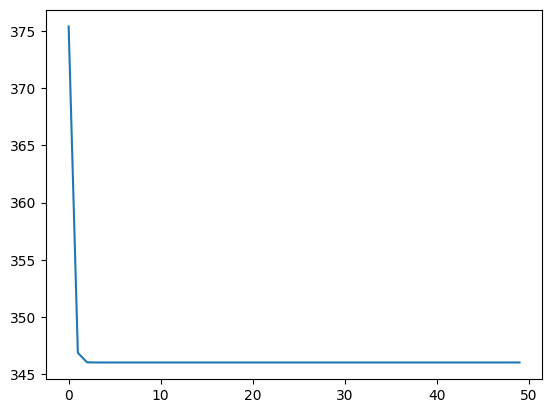

Test accuracy:  0.1985
Epoch 4
-------------------------------
	Client 0
-----------------------
loss: 1.331031  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
	Client 1
-----------------------
loss: 3.952616  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
	Client 2
-----------------------
loss: 5.676741  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5

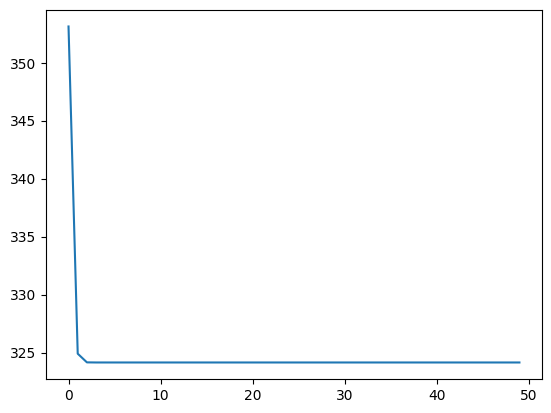

Test accuracy:  0.1032
Epoch 5
-------------------------------
	Client 0
-----------------------
loss: 2.997565  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
	Client 1
-----------------------
loss: 0.492681  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
	Client 2
-----------------------
loss: 1.603494  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5

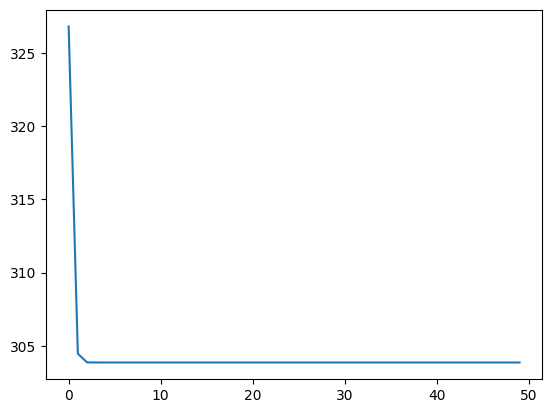

Test accuracy:  0.1965
Epoch 6
-------------------------------
	Client 0
-----------------------
loss: 1.540060  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
	Client 1
-----------------------
loss: 6.639340  [   64/ 5000]
loss: 0.000004  [   64/ 5000]
loss: 0.000004  [   64/ 5000]
loss: 0.000004  [   64/ 5000]
loss: 0.000003  [   64/ 5000]
loss: 0.000003  [   64/ 5000]
loss: 0.000002  [   64/ 5000]
loss: 0.000002  [   64/ 5000]
loss: 0.000002  [   64/ 5000]
loss: 0.000002  [   64/ 5000]
	Client 2
-----------------------
loss: 4.534361  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5

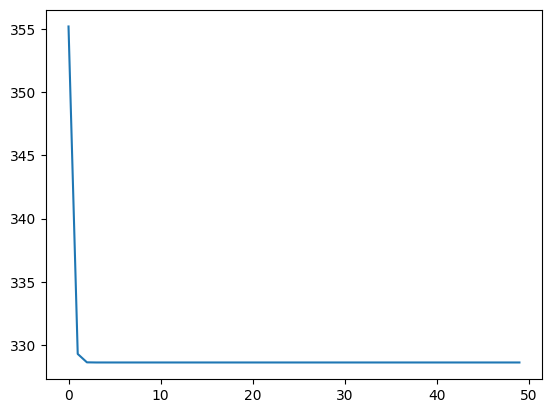

Test accuracy:  0.0981
Epoch 7
-------------------------------
	Client 0
-----------------------
loss: 2.347225  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
	Client 1
-----------------------
loss: 3.172853  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
	Client 2
-----------------------
loss: 0.537316  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5

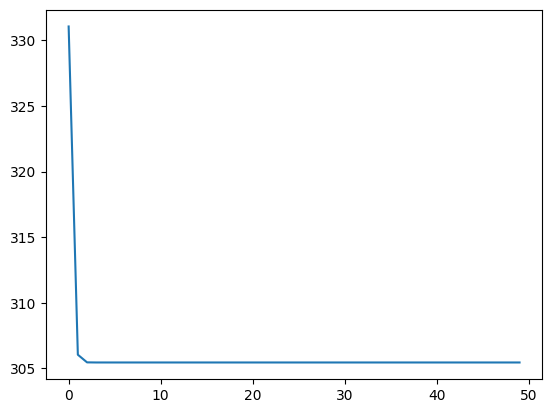

Test accuracy:  0.0997
Epoch 8
-------------------------------
	Client 0
-----------------------
loss: 1.258054  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
	Client 1
-----------------------
loss: 1.506974  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
	Client 2
-----------------------
loss: 4.427435  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5

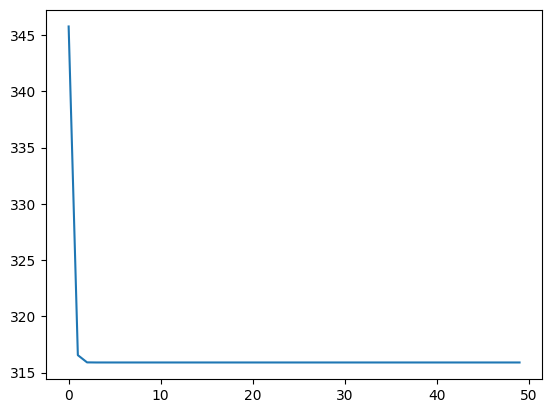

Test accuracy:  0.098
Epoch 9
-------------------------------
	Client 0
-----------------------
loss: 2.371998  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
	Client 1
-----------------------
loss: 2.431251  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
	Client 2
-----------------------
loss: 0.454386  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 50

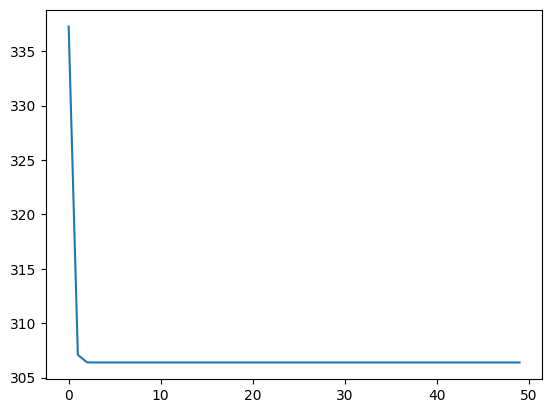

Test accuracy:  0.1077
Epoch 10
-------------------------------
	Client 0
-----------------------
loss: 1.218531  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
	Client 1
-----------------------
loss: 1.459291  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
	Client 2
-----------------------
loss: 4.478741  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 

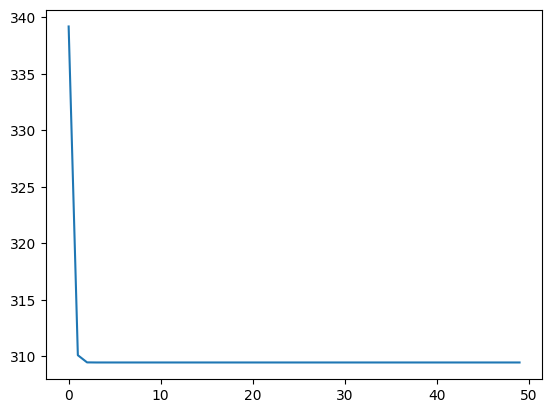

Test accuracy:  0.0981
Epoch 11
-------------------------------
	Client 0
-----------------------
loss: 2.115590  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
	Client 1
-----------------------
loss: 2.495002  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
	Client 2
-----------------------
loss: 0.655602  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 

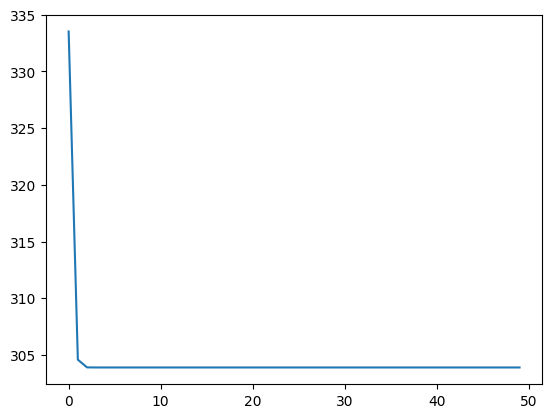

Test accuracy:  0.1511
Epoch 12
-------------------------------
	Client 0
-----------------------
loss: 1.425903  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
	Client 1
-----------------------
loss: 1.060427  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
	Client 2
-----------------------
loss: 3.913545  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 

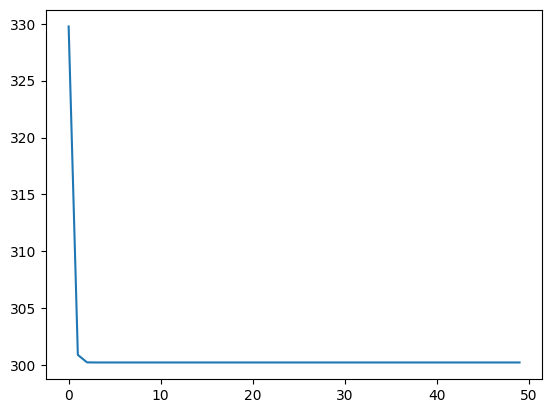

Test accuracy:  0.0979
Epoch 13
-------------------------------
	Client 0
-----------------------
loss: 2.527365  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
	Client 1
-----------------------
loss: 3.911371  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
	Client 2
-----------------------
loss: 0.420212  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 

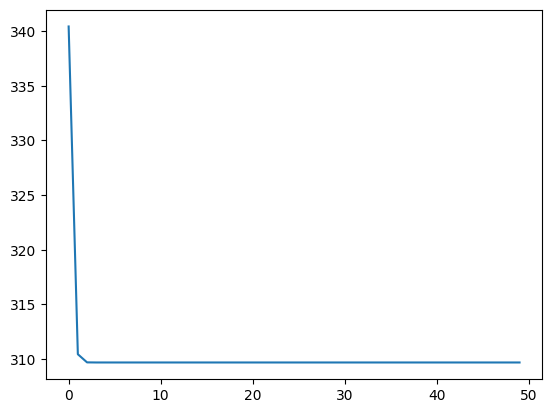

Test accuracy:  0.2073
Epoch 14
-------------------------------
	Client 0
-----------------------
loss: 1.523089  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
	Client 1
-----------------------
loss: 0.888619  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
	Client 2
-----------------------
loss: 3.674393  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 

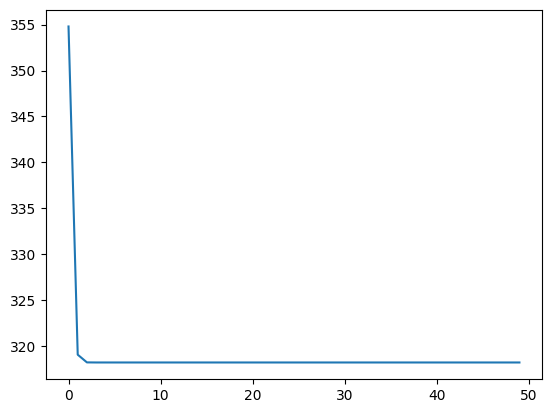

Test accuracy:  0.1012
Epoch 15
-------------------------------
	Client 0
-----------------------
loss: 1.836982  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
	Client 1
-----------------------
loss: 3.844320  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
	Client 2
-----------------------
loss: 0.550369  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 

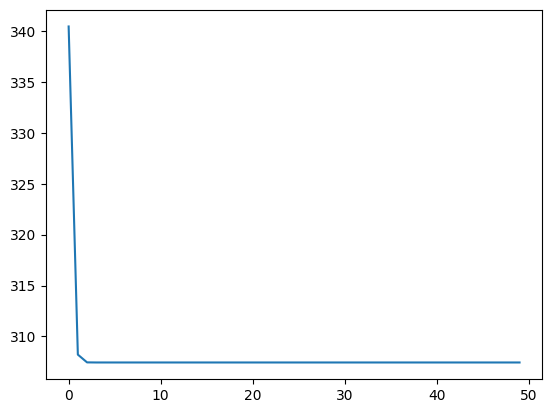

Test accuracy:  0.0958
Epoch 16
-------------------------------
	Client 0
-----------------------
loss: 1.863918  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
	Client 1
-----------------------
loss: 1.395936  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
	Client 2
-----------------------
loss: 3.923588  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 

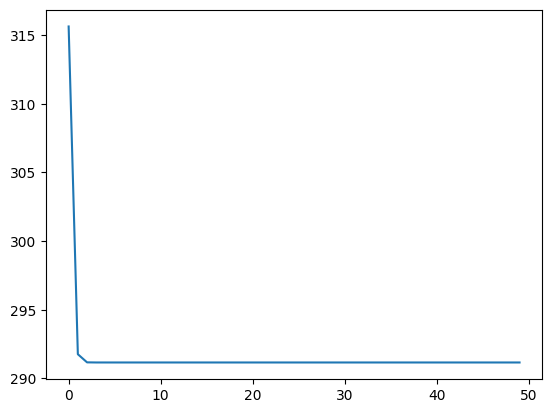

Test accuracy:  0.098
Epoch 17
-------------------------------
	Client 0
-----------------------
loss: 2.570824  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
	Client 1
-----------------------
loss: 3.441159  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
	Client 2
-----------------------
loss: 0.321831  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5

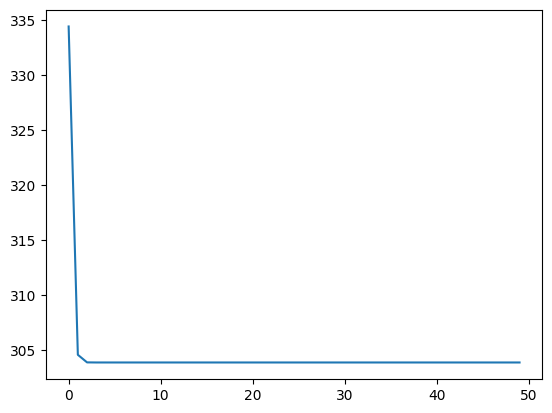

Test accuracy:  0.2382
Epoch 18
-------------------------------
	Client 0
-----------------------
loss: 1.402194  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
	Client 1
-----------------------
loss: 0.960627  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
	Client 2
-----------------------
loss: 3.744218  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 

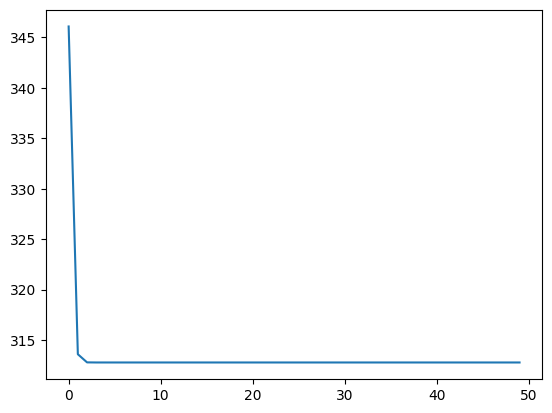

Test accuracy:  0.0996
Epoch 19
-------------------------------
	Client 0
-----------------------
loss: 1.481470  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
	Client 1
-----------------------
loss: 3.197864  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
	Client 2
-----------------------
loss: 0.614529  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 

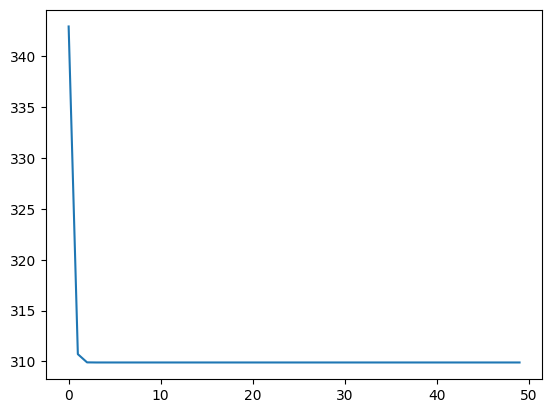

Test accuracy:  0.1175
Epoch 20
-------------------------------
	Client 0
-----------------------
loss: 1.732847  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
	Client 1
-----------------------
loss: 1.271260  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
	Client 2
-----------------------
loss: 3.550777  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 

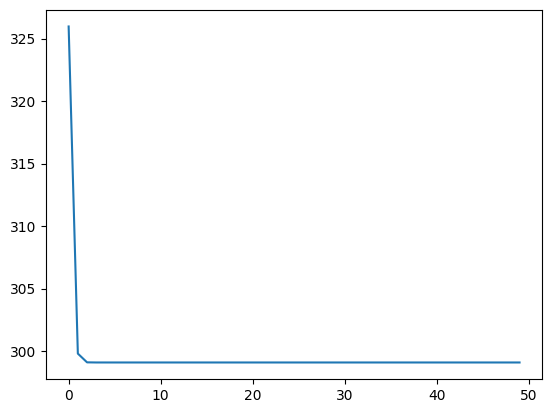

Test accuracy:  0.098
Epoch 21
-------------------------------
	Client 0
-----------------------
loss: 1.527923  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
	Client 1
-----------------------
loss: 2.967748  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
	Client 2
-----------------------
loss: 0.458408  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5

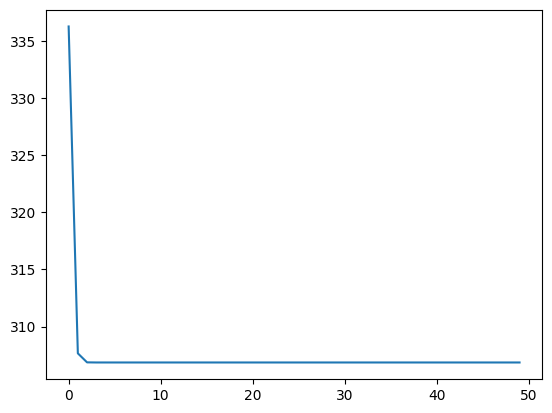

Test accuracy:  0.1716
Epoch 22
-------------------------------
	Client 0
-----------------------
loss: 2.152427  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
	Client 1
-----------------------
loss: 1.232542  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
	Client 2
-----------------------
loss: 4.003229  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 

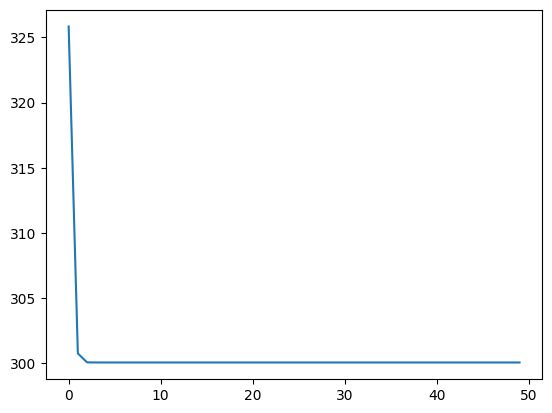

Test accuracy:  0.1854
Epoch 23
-------------------------------
	Client 0
-----------------------
loss: 0.829024  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
	Client 1
-----------------------
loss: 2.965643  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
	Client 2
-----------------------
loss: 0.786307  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 

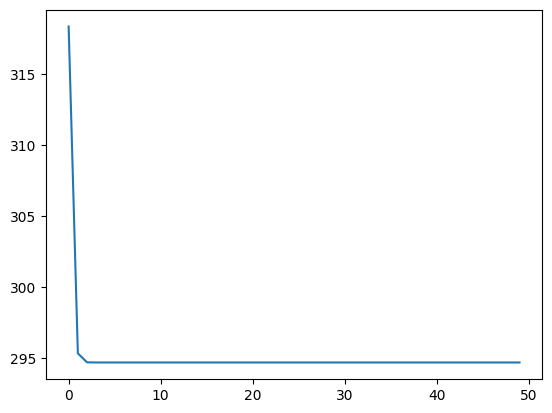

Test accuracy:  0.2067
Epoch 24
-------------------------------
	Client 0
-----------------------
loss: 2.760372  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
	Client 1
-----------------------
loss: 1.049995  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
	Client 2
-----------------------
loss: 3.310968  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 

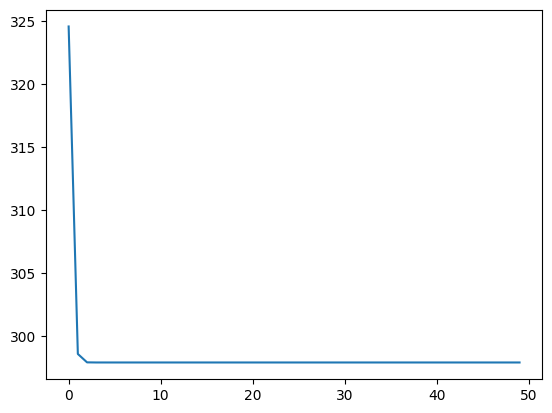

Test accuracy:  0.1843
Epoch 25
-------------------------------
	Client 0
-----------------------
loss: 0.937330  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
	Client 1
-----------------------
loss: 3.426705  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
	Client 2
-----------------------
loss: 0.891029  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 

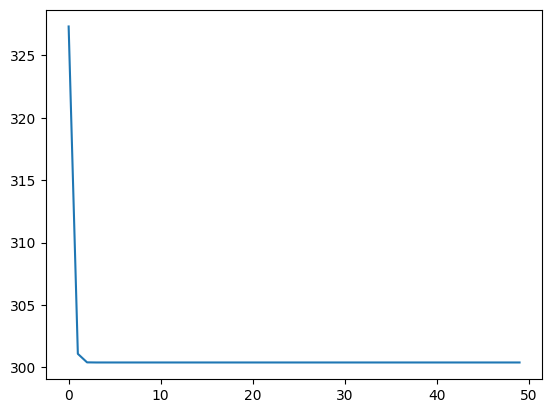

Test accuracy:  0.1554
Epoch 26
-------------------------------
	Client 0
-----------------------
loss: 2.330029  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
	Client 1
-----------------------
loss: 1.500793  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
	Client 2
-----------------------
loss: 2.665346  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 

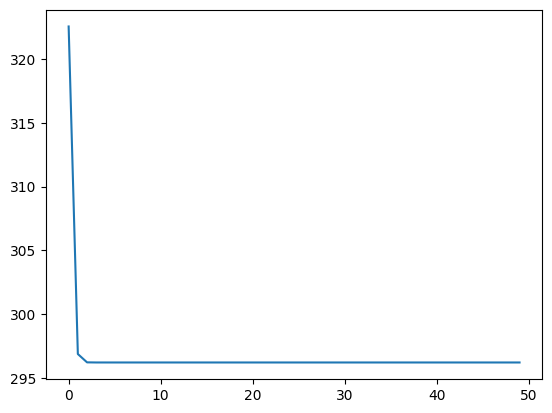

Test accuracy:  0.1073
Epoch 27
-------------------------------
	Client 0
-----------------------
loss: 1.131443  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
	Client 1
-----------------------
loss: 2.384290  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
	Client 2
-----------------------
loss: 0.673030  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 

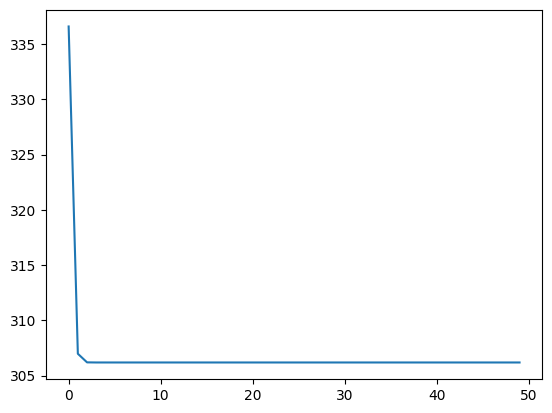

Test accuracy:  0.1747
Epoch 28
-------------------------------
	Client 0
-----------------------
loss: 2.263450  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
	Client 1
-----------------------
loss: 1.439731  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
	Client 2
-----------------------
loss: 3.422471  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 

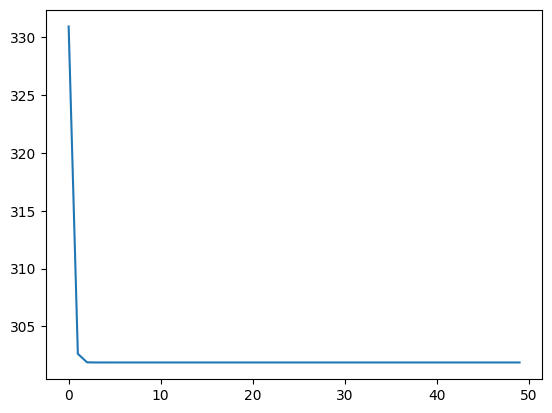

Test accuracy:  0.1713
Epoch 29
-------------------------------
	Client 0
-----------------------
loss: 0.891894  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
	Client 1
-----------------------
loss: 2.627810  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
	Client 2
-----------------------
loss: 0.756225  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 

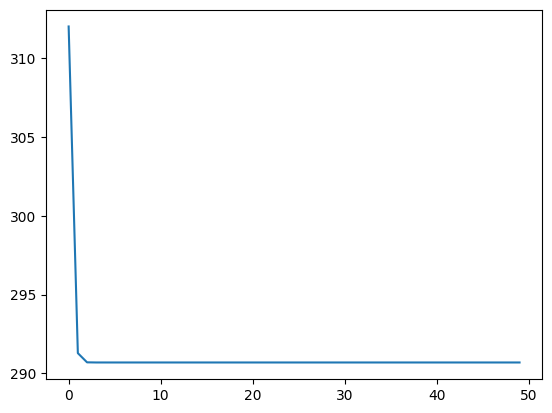

Test accuracy:  0.1963
Epoch 30
-------------------------------
	Client 0
-----------------------
loss: 2.630807  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
	Client 1
-----------------------
loss: 1.252115  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
	Client 2
-----------------------
loss: 3.355973  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 5000]
loss: 0.000000  [   64/ 

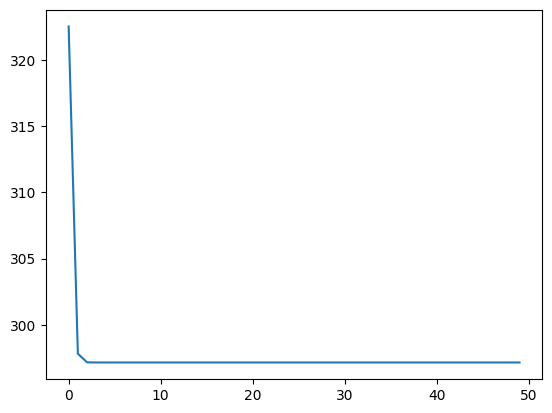

Test accuracy:  0.1723
Iteration complete! Saving results...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Done!


In [ ]:
# FL: FedTruth with attack CNN (check optimizer Adam)
# Change exp_name before run

exp_name = 'fl_contrib_040_noniid_cnn_FedTruth'
desc = '8 clients, same data size, noniid, 1-2 lable, cnn, 2024-1-30'

global_model = NeuralNetwork().to(device)

acc = []
contrib_loo = []
contrib_sv = []
contrib_fedtr = []
agg_wt_fedtr = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    local_state_dict = []
    global_state_dict = global_model.state_dict()

    # local training
    for i in range(num_clients):
      print(f"\tClient {i}\n-----------------------")

      local_model = NeuralNetwork().to(device)
      local_model.load_state_dict(global_model.state_dict())

      # optimizer = torch.optim.SGD(local_model.parameters(), lr=1e-3)
      optimizer = torch.optim.Adam(local_model.parameters(), lr=0.001)

      train_data = torch.utils.data.Subset(training_data, list(client_data[i]))
      train_dataloader = DataLoader(train_data, batch_size=batch_size)

      for ep in range(local_epochs):
        train(train_dataloader, local_model, loss_fn, optimizer)

      # send local model
      # amplifier attack
      if i in bad_client:
        loc_state_dict = local_model.state_dict()
        for name, param in local_model.named_parameters():
          param.data = loc_state_dict[name] * amp
        local_state_dict.append(local_model.state_dict())

      # normal clients
      else:
        local_state_dict.append(local_model.state_dict())

    # update global model
    client_data_size = [len(client_data[i]) for i in range(num_clients)]
    client_weights = [client_data_size[i]/sum(client_data_size) for i in range(num_clients)]

    agg_state_dict, obj, aw, contrib = fedtruth(local_state_dict, client_weights)
    plt.plot(obj)
    plt.show()

    for name, param in global_model.named_parameters():
      param.data = agg_state_dict[name]

    # compute test accuracy of global model
    test_acc = test(test_dataloader, global_model, loss_fn)
    print('Test accuracy: ', test_acc)
    acc.append(test_acc)

    # compute client contribution
    loo = client_contribution_loo(local_state_dict, aw)
    contrib_loo.append(loo)
    sv = client_contribution_shap_eff(local_state_dict, aw, global_state_dict)
    # sv = client_contribution_shap_fedtruth(local_state_dict, client_weights, global_state_dict)
    contrib_sv.append(sv)
    contrib_fedtr.append(contrib)
    # aggregation weight as contribution
    agg_wt_fedtr.append(aw)


contrib_loo = np.array(contrib_loo)
contrib_sv = np.array(contrib_sv)
contrib_fedtr = np.array(contrib_fedtr)
agg_wt_fedtr = np.array(agg_wt_fedtr)
acc = np.array(acc)

print('Iteration complete! Saving results...')


# Save and download results
from google.colab import files

save_data = {
    'exp_name': exp_name,
    'desc': desc,
    'acc': acc,
    'contrib_loo': contrib_loo,
    'contrib_sv': contrib_sv,
    'contrib_fedtr': contrib_fedtr,
    'agg_wt_fedtr': agg_wt_fedtr,
    'client_data_size': client_data_size,
    'client_data_distrib': client_distribution(training_data, client_data),

    # needed for rerun
    'client_data': client_data,
    'num_clients': num_clients,
    'epochs': epochs,
    'batch_size': batch_size,
    'local_epochs': local_epochs,
    'user_num_labels': user_num_labels,
    'client data function':
    'client_data = sample_client_non_iid(training_data, num_clients, user_num_labels, num_items = 5000)',

    # save final global model
    'final_global_state_dict': global_model.state_dict(),

    # attack
    'bad_client': bad_client,
    'amp': amp
}

with open(f'{exp_name}.pkl', 'wb') as f:
    pickle.dump(save_data, f)

files.download(f'{exp_name}.pkl')
print("Done!")

# Play sound
# from google.colab import output
# output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/0/05/Beep-09.ogg").play()')

In [ ]:
import pickle
# exp_name = 'fl_contrib_027_1attack_cnn_FedTruth'
with open(f'{exp_name}.pkl', 'rb') as f:
    exp102 = pickle.load(f)
print(exp102.keys())

In [ ]:
exp_data = exp102

n = exp_data['num_clients']
br1 = np.arange(n)
barWidth = 0.2
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
br4 = [x + barWidth for x in br3]

plt.bar(br1, np.average(exp_data['contrib_fedtr'], axis=0),
        label = 'Contribution_FedTruth', width = barWidth)
plt.bar(br2, np.average(exp_data['agg_wt_fedtr'], axis=0),
        label = 'Agg_wt_FedTruth', width = barWidth)

plt.bar(br3, np.average(softmax(minmaxscale(exp_data['contrib_sv'])), axis=0),
        label = 'Contribution_Shapley', width = barWidth)
plt.bar(br4, np.average(softmax(minmaxscale(exp_data['contrib_loo'])), axis=0),
        label = 'Contribution_LOO', width = barWidth)

plt.xlabel('Client')
plt.ylabel('Contribution')
plt.title(exp_data['desc'])
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.show()